In [1]:
# load and optionally install required packages
if (!require('pacman')) install.packages('pacman')
pacman::p_load(
    caret,
    dplyr,
    ggplot2,
    irr,
    readr,
    reshape
)

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
also installing the dependency ‘remotes’





The downloaded binary packages are in
	/var/folders/3l/l6pj_mwn0hd_47qlm6q6mb0c0000gn/T//Rtmp7AteeH/downloaded_packages


also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘colorspace’, ‘lava’, ‘farver’, ‘labeling’, ‘munsell’, ‘R6’, ‘RColorBrewer’, ‘viridisLite’, ‘pkgconfig’, ‘prodlim’, ‘cpp11’, ‘stringi’, ‘gtable’, ‘isoband’, ‘scales’, ‘tibble’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘data.table’, ‘dplyr’, ‘ellipsis’, ‘generics’, ‘gower’, ‘hardhat’, ‘ipred’, ‘lubridate’, ‘magrittr’, ‘purrr’, ‘tidyr’, ‘tidyselect’, ‘timeDate’, ‘stringr’, ‘ggplot2’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘withr’





  There is a binary version available but the source version is later:
      binary source needs_compilation
caret 6.0-92 6.0-93              TRUE


The downloaded binary packages are in
	/var/folders/3l/l6pj_mwn0hd_47qlm6q6mb0c0000gn/T//Rtmp7AteeH/downloaded_packages


installing the source package ‘caret’



caret installed

also installing the dependency ‘lpSolve’





The downloaded binary packages are in
	/var/folders/3l/l6pj_mwn0hd_47qlm6q6mb0c0000gn/T//Rtmp7AteeH/downloaded_packages



irr installed

also installing the dependencies ‘bit’, ‘prettyunits’, ‘bit64’, ‘progress’, ‘clipr’, ‘hms’, ‘vroom’, ‘tzdb’





The downloaded binary packages are in
	/var/folders/3l/l6pj_mwn0hd_47qlm6q6mb0c0000gn/T//Rtmp7AteeH/downloaded_packages



readr installed




The downloaded binary packages are in
	/var/folders/3l/l6pj_mwn0hd_47qlm6q6mb0c0000gn/T//Rtmp7AteeH/downloaded_packages



reshape installed



In [2]:
manual_scores <- read_csv('./data/generated/coalesced_manual_scored_twitter_usernames.csv')
botometer_scores.raw <- read_csv('./data/raw/scored_twitter_usernames.csv')

Rows: 150 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): username
dbl (2): bot_vote_count, total_votes
lgl (1): think_is_bot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 683071 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): username, checked_by, user_lang
dbl  (4): cap_english, cap_universal, raw_english, raw_universal
dttm (2): created_at, updated_at
date (1): date_checked

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
botometer_scores <- inner_join(manual_scores, botometer_scores.raw, by = c('username' = 'username')) %>%
select(
    username,
    think_is_bot,
    raw_universal
)

In [4]:
rate_cutoff <- function(cutoff){
    botometer_cutoff <- botometer_scores %>% mutate(
        cutoff_is_bot = raw_universal > cutoff
    )
    predicted <- factor(botometer_cutoff$cutoff_is_bot)
    expected <- factor(botometer_cutoff$think_is_bot)
    confusion <- confusionMatrix(data=predicted, reference = expected)
    return(confusion);
}

In [5]:
cutoff_data <- data.frame(
    cutoff=double(),
    accuracy=double(),
    sensitivity=double(),
    specificity=double(),
    precision=double(),
    recall=double()
)
for(cutoff in seq(0, 1, by=0.01)){
    confusion <- rate_cutoff(cutoff)
    cutoff_data <- cutoff_data %>%
    add_row(
        cutoff=cutoff,
        accuracy=confusion$overall[['Accuracy']],
        sensitivity=confusion$byClass[['Sensitivity']],
        specificity=confusion$byClass[['Specificity']],
        precision=confusion$byClass[['Precision']],
        recall=confusion$byClass[['Recall']]
    )
}

Warning message in confusionMatrix.default(data = predicted, reference = expected):
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = predicted, reference = expected):
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = predicted, reference = expected):
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = predicted, reference = expected):
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = predicted, reference = expected):
“Levels are not in the same order for reference and data. Refactoring data to match.”


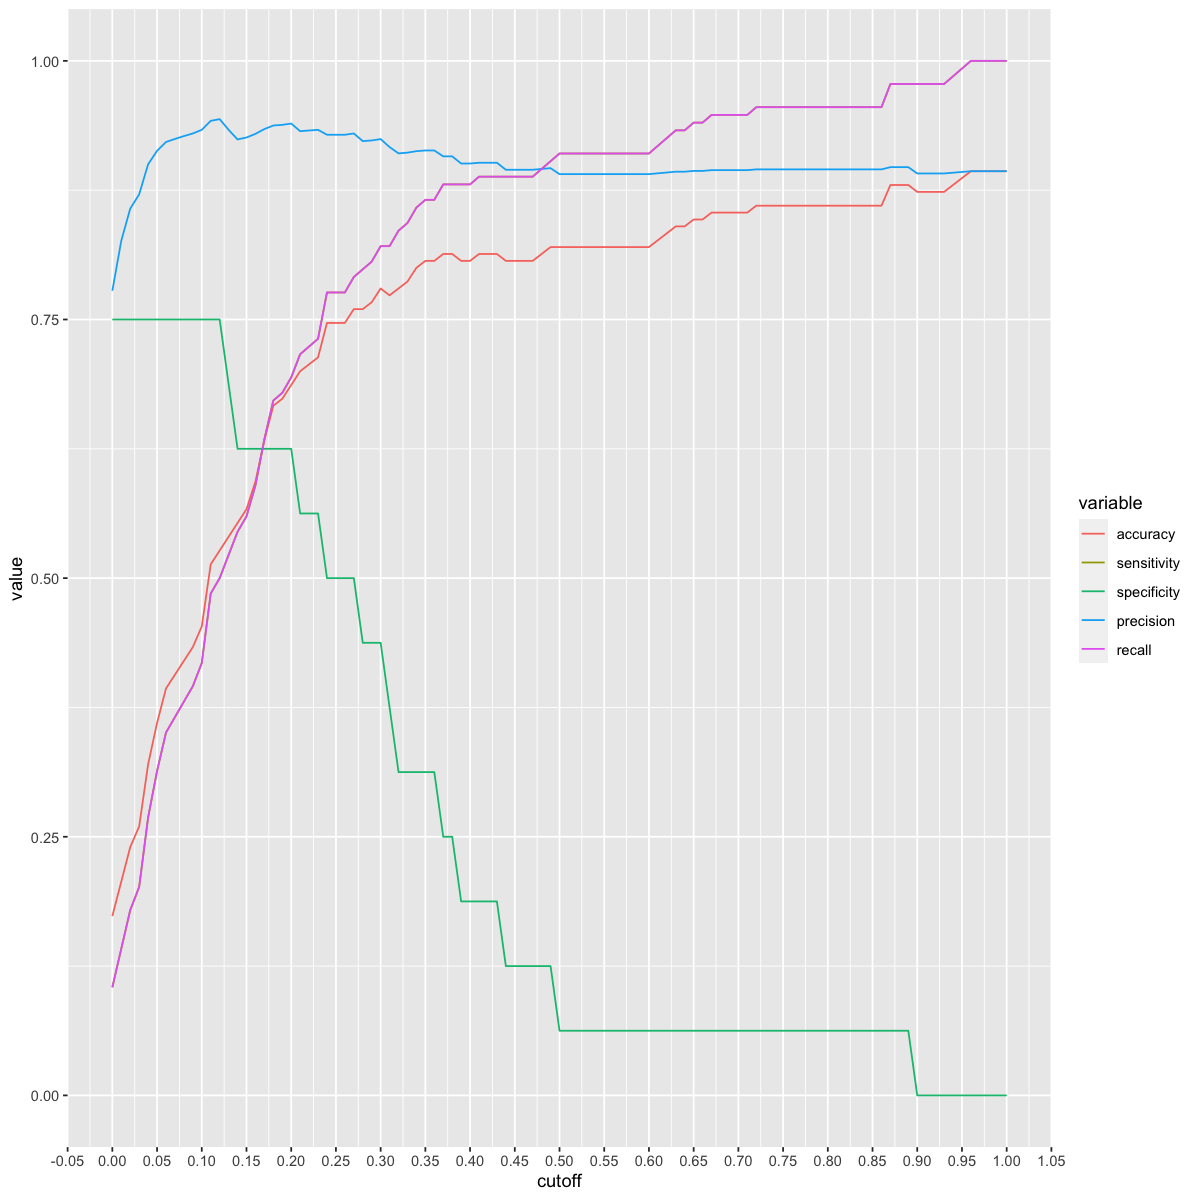

In [6]:
melted_data <- cutoff_data %>% melt(id.vars=c('cutoff'))
options(repr.plot.width=10, repr.plot.height=10)
melted_data %>% ggplot(aes(x=cutoff, y=value, group=variable, color=variable)) +
    geom_line() +
    scale_x_continuous(breaks = scales::pretty_breaks(n=20))

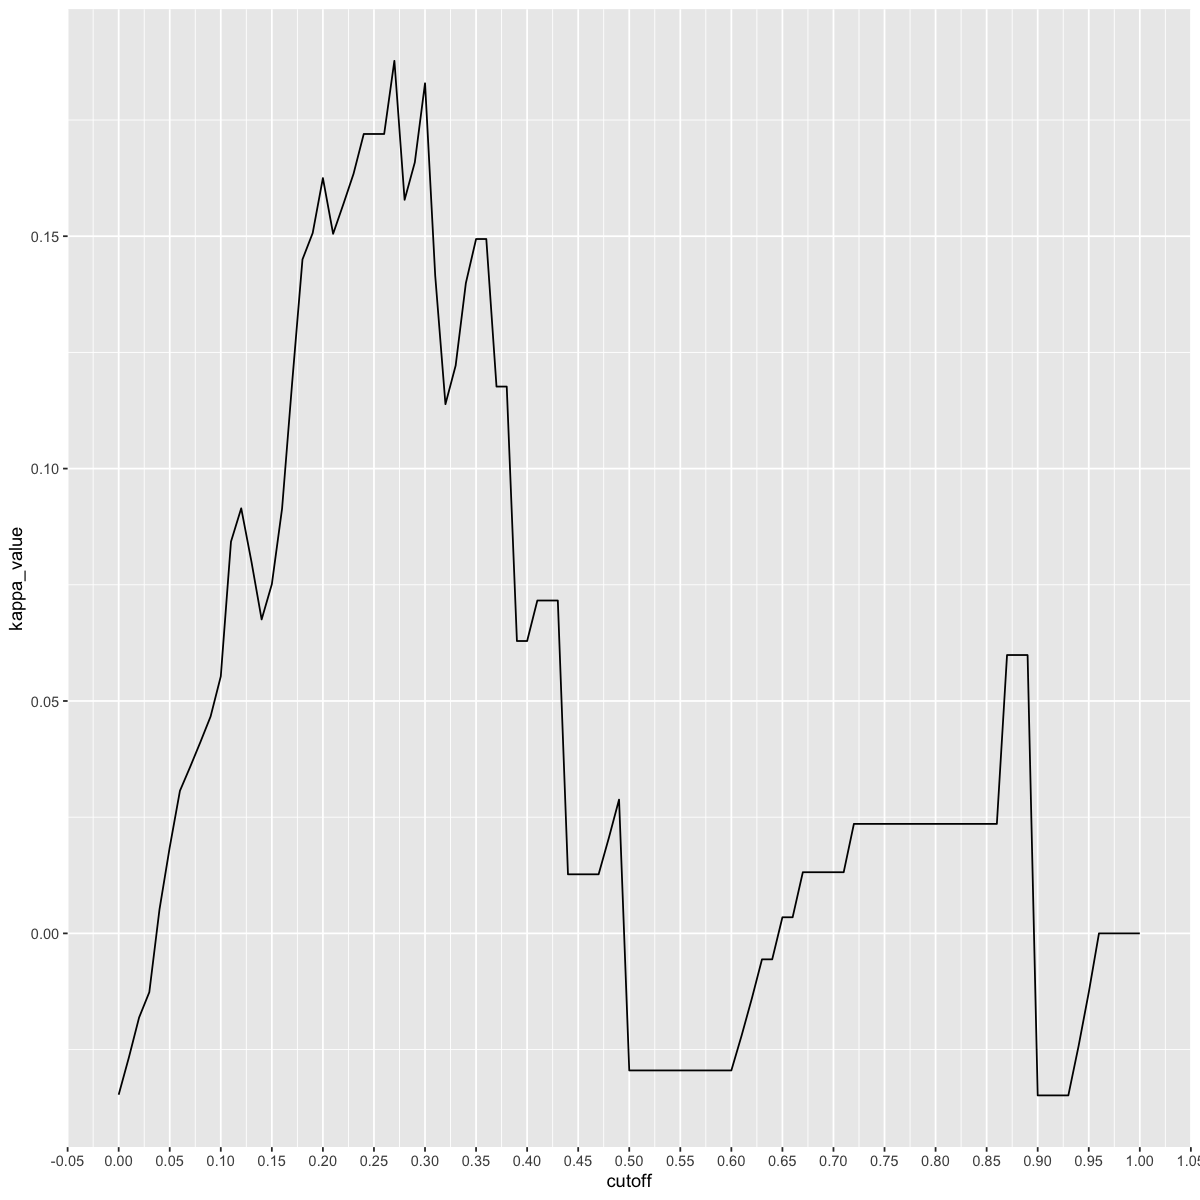

In [8]:
kappas_data <- tibble(
    cutoff = numeric(),
    kappa_value = numeric()
)
rate_kappa <- function(cutoff){
    botometer_cutoff <- botometer_scores %>% mutate(
        cutoff_is_bot = raw_universal > cutoff
    )
    #predicted <- factor(botometer_cutoff$cutoff_is_bot)
    #expected <- factor(botometer_cutoff$think_is_bot)
    
    return(kappa2(botometer_cutoff %>% select(cutoff_is_bot, think_is_bot))$value)
}
for(cutoff in seq(0, 1, by=0.01)){
    kappa_value <- rate_kappa(cutoff)
    kappas_data <- kappas_data %>% add_row(cutoff=cutoff, kappa_value=kappa_value)
}
ggplot(kappas_data, aes(x=cutoff, y=kappa_value)) +
    geom_line() +
    scale_x_continuous(breaks = scales::pretty_breaks(n=20))

In [9]:
# cutoff is 0.43
bots <- botometer_scores.raw %>% filter(raw_universal > 0.43)

In [10]:
(bots %>% nrow()) / (botometer_scores.raw %>% nrow())

[1] 0.1176496

In [11]:
bots %>% select(username) %>% write_csv('./data/generated/botometer_usernames_by_cutoff.csv')